## Data 620 - Week 10

### Team No. 6

- Yohannes Deboch
- Sherranette Tinapunan

### Video Presentation

Part 1: https://screencast-o-matic.com/watch/cqfbfpZ0Kj

Part 2: https://screencast-o-matic.com/watch/cqfbheZ072

---

### Assignment 

It can be useful to be able to classify new "test" documents using already classified "training" documents.  A common example is using a corpus of labeled spam and ham (non-spam) e-mails to predict whether or not a new document is spam.  Here is one example of such data:  http://archive.ics.uci.edu/ml/datasets/Spambase

For this project, you can either use the above dataset to predict the class of new documents (either withheld from the training dataset or from another source such as your own spam folder).

For more adventurous students, you are welcome (encouraged!) to come up a different set of documents (including scraped web pages!?) that have already been classified (e.g. tagged), then analyze these documents to predict how new documents should be classified.

---

### Data set

http://spamassassin.apache.org/old/publiccorpus/

### Libraries

In [1]:
import numpy as np
import pandas as pd

from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer
import re #regular expression
import glob

#sklearn
#from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

### Functions

<b>get_documents</b> is a function that takes a path to a folder that contains files and a value of 1 or 0 that specifies if the documents in the folder are spam or not. The function expects that all spam messages are contained in a single folder and all ham messages are contained in a single folder as well. The expected encoding is "utf8". If an error errors while reading a document, the error is ignored and the next document is read. 

- <i>folerpath</i>: path to the folder
- <i>spam_value</i>: 1 if the messages in the folder are spam. 0 if the messages in the folder are not spam. 

This function returns a data frame of messages with the columns 'spam' and 'message'. 

In [2]:
#folderpath: relative path to the folder that contains texts classified as either spam or ham
#spam_value: pass '1' if documents in folder are spam; pass '0' if documents in folder are ham.
#this function skips any documents that generates errors due to unrecognized encoding
def get_documents(folderpath, spam_value):
    filepath_list = glob.glob(folderpath)
    d = list()
    for filepath in filepath_list:
        file_object  = open(filepath, "r", encoding="utf8", errors='ignore')
        message = file_object.read()
        document = {'spam':[spam_value], 'message': [message]}
        d.append(pd.DataFrame(document))
    return pd.concat(d) #return dataframe

<b>get_alphawords</b> is a function that takes a string and extracts words with alpha characters. 
Trailing and leading spaces are removed. English stop words are removed. The words are stemmed.
A string is returned.

In [3]:
#extract only alpha characters, remove english stopwords, and stem words
def get_alphawords(message):
    message = message.lower()
    #only look at alpha characters
    thispattern = "[a-z]+ |[a-z]+[a-z]$|[a-z]+[\\.|,|;] "
    alpha_words_list = re.findall(thispattern, message)
    words_strip = [word.strip() for word in alpha_words_list] #remove leading/trailing spaces
    sw = stopwords.words('english')
    words = [word for word in words_strip if word not in sw] #remove stop words
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join([word for word in stemmed_words]) #return a string

#### Load spam and ham documents 

Load the spam and ham documents from the specified folder. Mark spam messages with 'spam = 1' and mark ham messages with 'spam = 0'. The spam and ham text documents are loaded onto their respective dataframes.  

In [4]:
spam_data = get_documents('spamham/spam_all/*', 1) 
ham_data = get_documents('spamham/ham_all/*', 0)

#### Size of spam and ham

There are 1,896 spam documents and 4,202 ham documents. 

In [5]:
print(spam_data.shape)
print(ham_data.shape)

(1896, 2)
(4202, 2)


#### Preview documents

In [6]:
spam_data.head()

,spam,message
0,1,From ilug-admin@linux.ie Tue Aug 6 11:51:02 ...
0,1,From 12a1mailbot1@web.de Thu Aug 22 13:17:22 ...
0,1,From lmrn@mailexcite.com Mon Jun 24 17:03:24 ...
0,1,From ilug-admin@linux.ie Thu Aug 22 13:27:39 ...
0,1,From sabrina@mx3.1premio.com Thu Aug 22 14:44...


In [7]:
ham_data.head()

,spam,message
0,0,Return-Path: <exmh-workers-admin@spamassassin....
0,0,From exmh-workers-admin@redhat.com Wed Aug 21...
0,0,From exmh-workers-admin@redhat.com Wed Aug 21...
0,0,From exmh-workers-admin@redhat.com Wed Aug 21...
0,0,From exmh-workers-admin@redhat.com Wed Aug 21...


#### Preview of a single document before clean up

Below is an example document. As you can see, the document contains a lot of formatting data.

In [8]:
spam_data.iloc[0]['message']

'From ilug-admin@linux.ie  Tue Aug  6 11:51:02 2002\nReturn-Path: <ilug-admin@linux.ie>\nDelivered-To: yyyy@localhost.netnoteinc.com\nReceived: from localhost (localhost [127.0.0.1])\n\tby phobos.labs.netnoteinc.com (Postfix) with ESMTP id 9E1F5441DD\n\tfor <jm@localhost>; Tue,  6 Aug 2002 06:48:09 -0400 (EDT)\nReceived: from phobos [127.0.0.1]\n\tby localhost with IMAP (fetchmail-5.9.0)\n\tfor jm@localhost (single-drop); Tue, 06 Aug 2002 11:48:09 +0100 (IST)\nReceived: from lugh.tuatha.org (root@lugh.tuatha.org [194.125.145.45]) by\n    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g72LqWv13294 for\n    <jm-ilug@jmason.org>; Fri, 2 Aug 2002 22:52:32 +0100\nReceived: from lugh (root@localhost [127.0.0.1]) by lugh.tuatha.org\n    (8.9.3/8.9.3) with ESMTP id WAA31224; Fri, 2 Aug 2002 22:50:17 +0100\nReceived: from bettyjagessar.com (w142.z064000057.nyc-ny.dsl.cnc.net\n    [64.0.57.142]) by lugh.tuatha.org (8.9.3/8.9.3) with ESMTP id WAA31201 for\n    <ilug@linux.ie>; Fri, 2 Aug 2002 

#### Extract words with letters only

The function <b>get_alphawords</b> is used to extract words with alpha characters only.

In [9]:
spam_data['message_alphawords'] = spam_data['message'].apply(lambda x: get_alphawords(x))
ham_data['message_alphawords'] = ham_data['message'].apply(lambda x: get_alphawords(x))

Combine spam and ham data into a single data frame 'data'. There are, in total, 6,098 documents.

In [10]:
data = spam_data.append(ham_data)
data = data.drop(['message'], axis=1)
data.columns = ['spam', 'message']
len(data)

6098

#### After clean up

In [11]:
data.iloc[0]['message']

'ie tue aug localhost localhost com esmtp id tue, aug phobo localhost imap localhost tue, aug org org org esmtp id fri, aug lugh localhost esmtp id fri, aug com org esmtp id fri, aug host claim id fri, aug fri, aug start plain; stop mlm irish linux group receiv letter express interest receiv inform onlin busi opportunities. erron pleas accept sincer apology. time mailing, remov burned, betrayed, stab level marketing, mlm, pleas read letter. could import one ever land level market huge mistak mlm fail deliv promis past years. pursuit mlm cost hundr thousand peopl friends, fortun sacr honor. fact mlm fatal flawed, mean cannot work compani earn big money mlm go tell real story. finally, someon courag cut hype lie tell truth good altern mlm works, work yet abandon dreams, need see this. earn kind incom dream easier permission, like send brief letter tell mlm work peopl introduc someth new refresh wonder heard promis unwant follow up, sale pitch, one call you, email address use send informa

#### Create 'x' and 'y' 

The <b>sklearn</b> library is used to create the model that classifies documents are either spam or not spam. 

- The <b>x</b> data is the text of the document (independent variable). 
- The <b>y</b> data is the spam status of 1 or 0 (dependent variable). The y variable is what the model is going to predict.

In [12]:
df_x = data['message']
df_y = data['spam']

#### Split data into training and test

The function <b>train_test_split</b> of <i>sklearn.model_selection</i> is used to split the data into random train and test subsets. The test size is set to 25%. 

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html


Training data - 75% 
- <i>x_train</i> - message data used to train the model (independent)
- <i>x_test</i> - corresponding spam status used to train the model (dependent)

Test data - 25%
- <i>y_train</i> - message data used to test predictions of model (independent)
- <i>y_test</i> - corresponding actual spam status that model attempts to predict 

In [13]:
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.25, random_state=4)

print(len(x_test))
print(len(y_test))

print(len(x_train))
print(len(y_train))

1525
1525
4573
4573


### Term Frequency - Inverse Document Frequency (TF-IDF)

Sklearn's TF-IDF vectorizer function was used to generate the term frequency-inverse document frequency value for each of the word in the training and test message data. 

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

<b>min_df</b>: float in range [0.0, 1.0] or int (default=1)
When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

The line of code below create a TF-IDF vectorizer object. This vectorizer removes stop words in the English language. 


In [14]:
#generate a tf-idf vectorizer
tfidf_vec = TfidfVectorizer(min_df=1, stop_words='english')


Explanation of what <b>fit_transform</b> does: 

https://datascience.stackexchange.com/questions/12321/difference-between-fit-and-fit-transform-in-scikit-learn-models

The <b>fit_transform</b> is run on te train 'x' data. This calculates the mean and standard deviations, which are used to normalize the data.  
    

In [15]:
x_train_tfidf = tfidf_vec.fit_transform(x_train)

There are 30,817 features in the train set (unique words). 

In [16]:
print(len(tfidf_vec.get_feature_names()))

30817


#### Preview of feature names in train data

In [17]:
tfidf_vec.get_feature_names()[0:20]

['aa',
 'aaa',
 'aaar',
 'aac',
 'aachen',
 'aacute',
 'aad',
 'aag',
 'aalib',
 'aaliyah',
 'aaron',
 'aaronsw',
 'aatr',
 'aavid',
 'aavishkar',
 'aaxin',
 'ab',
 'abacha',
 'abandon',
 'abastecimientos']

#### A demo of the tfidf output

The tfidf vectorizer output is an array of list that gives the tfidf value of the words in the tfidf_vec.get_feature_names(). These feature names are the 'columns names' of the array of list. Each list in the array represents a document. 

In [18]:
a = x_train_tfidf.toarray()
print(a)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


As you can see, the tfidf output has 4,573 rows (number of documents in the train set) and 30,817 columns (number of distinct terms or words in the entire train set). Each value in the array is a tfidf score of the corresponding term in the document. 

In [19]:
a.shape

(4573, 30817)

The <b>inverse_transform</b> function maps an array element back to the words in the document. 

The example below selects the tf-idf output of the first document in the train set, a[0], and passes this to the inverse_transform function. The x_train.iloc[0] shows you the content of the message of the first document in the train set. 

In [20]:
tfidf_vec.inverse_transform(a[0])

[array(['anoth', 'anyth', 'au', 'bad', 'click', 'codebase', 'com', 'cut',
        'discuss', 'display', 'dn', 'elz', 'esmtp', 'exampl', 'exmh',
        'fail', 'fri', 'guess', 'gvim', 'id', 'imap', 'jalapeno', 'kind',
        'list', 'localdomain', 'localhost', 'mail', 'messag', 'mozilla',
        'netscap', 'nugent', 'odd', 'org', 'past', 'plain', 'processes',
        'robert', 'script', 'sep', 'smtp', 'suppos', 'task', 'th', 'thing',
        'toni', 'use', 'user', 'window', 'wish', 'xterm'], dtype='<U36')]

In [21]:
x_train.iloc[0]

'com fri sep localhost jalapeno org esmtp id fri, sep jalapeno localhost imap localhost fri, sep com com org esmtp id fri, sep com localdomain com esmtp id e; fri, sep com com esmtp id fri, sep com id com; fri, sep com com com smtp id fri, sep th smtp id fri, sep au th th esmtp id fri, sep au localhost esmtp id fri, sep robert elz bad click plain; discuss list exmh user fri, sep no, fri, sep toni nugent past messag display window gvim processes, anyth odd. cut past kind window exmh mozilla, xterm, anoth wish script mine use dn task one guess netscap use use suppos mozilla codebase, thing anyth fail for, exampl anyth fail user mail'

### Multinomial Naive Bayes

Multinomail Navie Bayes is used to create the spam classifier. 

The <b>MultinomialNB</b> class of <i>sklearn.naive_bayes</i> library is used to create this object. 

The line of code below creates a Multinomial Naive Bayes object.

In [22]:
mnb = MultinomialNB()

Make sure that the <b>y_train</b> data type is <b>int</b>.

In [23]:
y_train = y_train.astype('int')

### Fit x, y data with multinomial naive bayes

About MultinomialNB fit: 

https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB.fit

The x_train's tfidf array is passed along with the target values. The fit is done with alpha=1.0. 

Choosing parameter <i> alpha </i>: 

https://stackoverflow.com/questions/33830959/multinomial-naive-bayes-parameter-alpha-setting-scikit-learn



In [24]:
mnb.fit(x_train_tfidf, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

#### Run the 'transform' function on the test data

The tfidf vectorizer object's <i>transform</i> function is used for the test data. It's important that the 'fit_transform' function is NOT used for this purpose. The transform function uses the same mean and standard deviation used for the train set. If the 'fit_transform' function is used on the test set, this will generate a new mean and standard deviation. 

In [25]:
x_test_tfidf = tfidf_vec.transform(x_test)
print(len(x_test))
print(x_test_tfidf.shape)

1525
(1525, 30817)


In [26]:
len(tfidf_vec.get_feature_names())

30817

#### Predict spam status of test data

The MultinomialNB's <i>predict</i> function is used to predict the spam status of the test data based on the multinomial naive bayes model that was built earlier with the train data. The predict function takes the tfidf data of the test set. 

In [27]:
print(x_test_tfidf.shape)
predict = mnb.predict(x_test_tfidf)
print(len(predict))


(1525, 30817)
1525


#### Compare predicted and actual spam status of test data

The <i>y_test</i> variable holds the actual spam status of the test data. 

In [28]:
actual = np.array(y_test)
len(actual)

1525

The code below compares the spam status of each document in the test set and increments <i>count</i> by 1 if the predicted spam status matches the actual spam status of the document. 

In [29]:
count = 0
for i in range(len(predict)):
    if predict[i] == actual[i]:
        count = count + 1

There are 1,525 documents in the test set, and the model correctly classified 1,396 of these documents. 

<b>This model has a 91.54% accuracy.</b>

In [30]:
print(len(predict))
print(len(actual))
print(count)

1525
1525
1396


In [31]:
count/len(predict)

0.9154098360655738

In [32]:
#475 documents in test set that are spam
print((actual == 1).sum())

#1050 documens in test set that are not spam 
print((actual == 0).sum())

#375 out of 475 spam documents were correctly classified as spam
print((predict[np.isin(actual, [1])] == 1).sum())

#1021 out of 1050 ham documents were correctly classified as not spam 
print((predict[np.isin(actual, [0])] == 0).sum())

475
1050
375
1021


- About 79% of spam documents were correctly classified. 
- About 97% of not spam documents were correctly classsified.  

In [33]:
#correctly classified spam
print(375/475)

#correctly classified not spam
print(1021/1050)

0.7894736842105263
0.9723809523809523


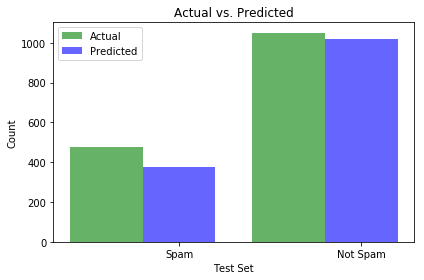

In [35]:
import matplotlib.pyplot as plt

# data to plot
n_groups = 2
actual_status = (475, 1050)
predicted_status = (375, 1021)
 
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.40
opacity = 0.6
 
rects1 = plt.bar(index, actual_status, bar_width,
alpha=opacity,
color='green',
label='Actual')
 
rects2 = plt.bar(index + bar_width, predicted_status, bar_width,
alpha=opacity,
color='blue',
label='Predicted')
 
plt.xlabel('Test Set')
plt.ylabel('Count')
plt.title('Actual vs. Predicted')
plt.xticks(index + bar_width, ('Spam', 'Not Spam'))
plt.legend()
 
plt.tight_layout()
plt.show()

- 375 out of 475 spam documents were correctly classified as spam (~79% accuracy)
- 1021 out of 1050 ham documents were correctly classified as not spam (~97% accuracy)

#### Resources

Tutorial on Sklearn Vectorizer and Multinomial Naive Bayes

- CountVectorizer: https://youtu.be/RZYjsw6P4nI
- TFIDF: https://www.youtube.com/watch?v=bPYJi1E9xeM


Helpful information on term frequency-inverse document frequency 
- https://towardsdatascience.com/spam-classifier-in-python-from-scratch-27a98ddd8e73

---

Team No. 6